# Regresja logistyczna i SVM

Opis regresji logistycznej autorstwa Magdaleny Trędowicz został zapożyczony z zajęć Olimpijskiego Koła Sztucznej Inteligencji na Uniwersytecie Jagiellońskim.

In [1]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_moons

## Regresja logistyczna
Załóżmy, że każdy przykład ze zbioru danych $x_i \in X$ ma przypisaną etykietę $y_i \in \{1, \ldots, K \}$.
Regresja logistyczna jest jednym z klasycznych modeli, który bezpośrednio nadaje się zarówno do klasyfikacji binarnej (dwie klasy: $y_i \in \{0,1\}$), jak i wieloklasowej. 
Ten model jest o tyle ważny, że stanowi podstawę modeli klasyfikacyjnych opartych o sieci neuronowe. 

Regresja logistyczna tworzy model probabilistyczny określający prawdopodobieństwo przynależności punktu do poszczególnych klas. 
W tym modelu chcemy dla każdego punktu wyznaczyć tak zwany rozkład a posteriori $p(1|x_i),\ldots,p(K|x_i)$ określający przynależność punktu $x_i$ do każdej z $K$ klas. Jako finalną decyzję o klasyfikacji przyjmujemy tę najbardziej prawdopodobną, czyli:

$$
c(x) = \arg \max_{k \in \{1, \dots, K\}} p(k | x_i).
$$

Żeby zbudować taki model, musimy sparametryzować prawdopodobieństwa a posteriori, a następnie zbudować funkcję kosztu definiującą kryterium optymalizacyjne. W celu sparametryzowania $p(k|\cdot)$, określmy moc przyporządkowania punktu $x$ do klasy $k$, wykorzystując model liniowy postaci:

$$
f_k(x) = w_k^Tx+b_k \in \mathbb{R}, \quad \text{dla} \quad k \in \{1, \ldots, K\}.
$$

Mając $K$ takich modeli liniowych, możemy wskazać najbardziej prawdopodobną klasę poprzez wyznaczenie największej wartości $f_k(x)$ dla $k \in \{1, \ldots, K\}$.
W celu transformacji tcyh funkcji do prawdopodobieństw wykorzystamy funkcję **softmax** postaci:

$$
p(k|x) = \frac{\exp(z_k)}{\sum_{j=1}^{K}\exp(z_j)} \in (0,1),
$$

gdzie $z_k = f_k(x) = w_k^Tx + b_k.$

### Zadanie 1 (4 punkty)
Wyucz model regresji logistycznej na zbiorze danych Iris, tak że:
- Klasyfikator używa tylko jednej zmiennej - szerokości płatka (petal width) oraz wykrywa tylko jedną klasę - Virginica.
- Podziel dane na zbiór treningowy, walidacyjny i testowy. Następnie zrób grid search w celu dobrania optymalnego hiperparametru $C$ (jego opis można znaleźć tutaj: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Grid search powinien uwzględnić przynajmniej 10 różnych wartości $C$.
- Narysuj wykres przedstawiący dokładność klasyfikatora na zbiorze testowym w zależności od wartości hiperparametru $C$. 
- Narysuj wykres przedstawiający granicę decyzyjną klasyfikatora. Na osi OX powinna być długość płatka (petal width), a na osi OY prawdopodobieństwo przynależności kwiatu do danej klasy. Taki wykres powinien być narysowany w oparciu o dane testowe.

Nie zapomnij podpisać wykresów oraz dodać legendy!

In [3]:
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [4]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

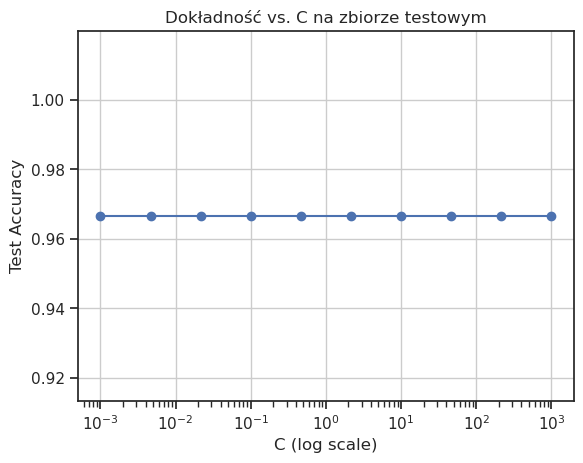

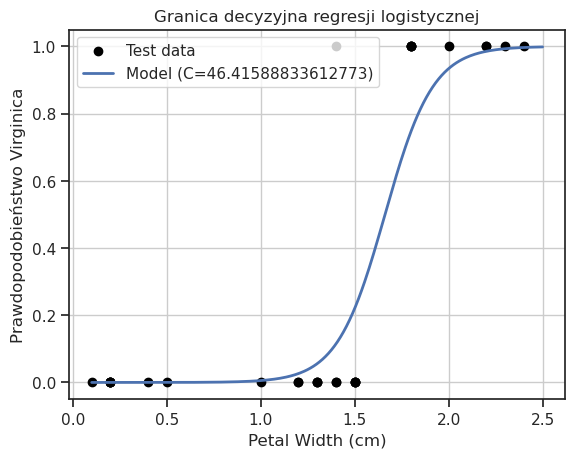

In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. Wczytanie danych
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['species'] = pd.Categorical.from_codes(iris.target, categories=iris.target_names)
iris_df['is_virginica'] = (iris_df['species'] == 'virginica').astype(int)

# 2. Wybór jednej cechy
X = iris_df[['petal width (cm)']].values
y = iris_df['is_virginica'].values

# 3. Podział danych
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# 4. GridSearchCV
param_grid = {'C': np.logspace(-3, 3, 10)}
grid = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid.fit(X_train, y_train)

# 5. Wykres: Dokładność vs C
test_scores = []
for C in param_grid['C']:
    model = LogisticRegression(C=C, solver='liblinear')
    model.fit(X_train, y_train)
    test_score = model.score(X_test, y_test)
    test_scores.append(test_score)

plt.plot(param_grid['C'], test_scores, marker='o')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Test Accuracy')
plt.title('Dokładność vs. C na zbiorze testowym')
plt.grid()
plt.show()

# 6. Wykres: Granica decyzyjna
best_C = grid.best_params_['C']
best_model = LogisticRegression(C=best_C, solver='liblinear')
best_model.fit(X_train, y_train)


best_C = grid.best_params_['C']
print("Najlepsze C:", best_C)

X_plot = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
probas = best_model.predict_proba(X_plot)[:, 1]

plt.scatter(X_test, y_test, label='Test data', c='black')
plt.plot(X_plot, probas, label=f'Model (C={best_C})', linewidth=2)
plt.xlabel('Petal Width (cm)')
plt.ylabel('Prawdopodobieństwo Virginica')
plt.title('Granica decyzyjna regresji logistycznej')
plt.legend()
plt.grid()
plt.show()


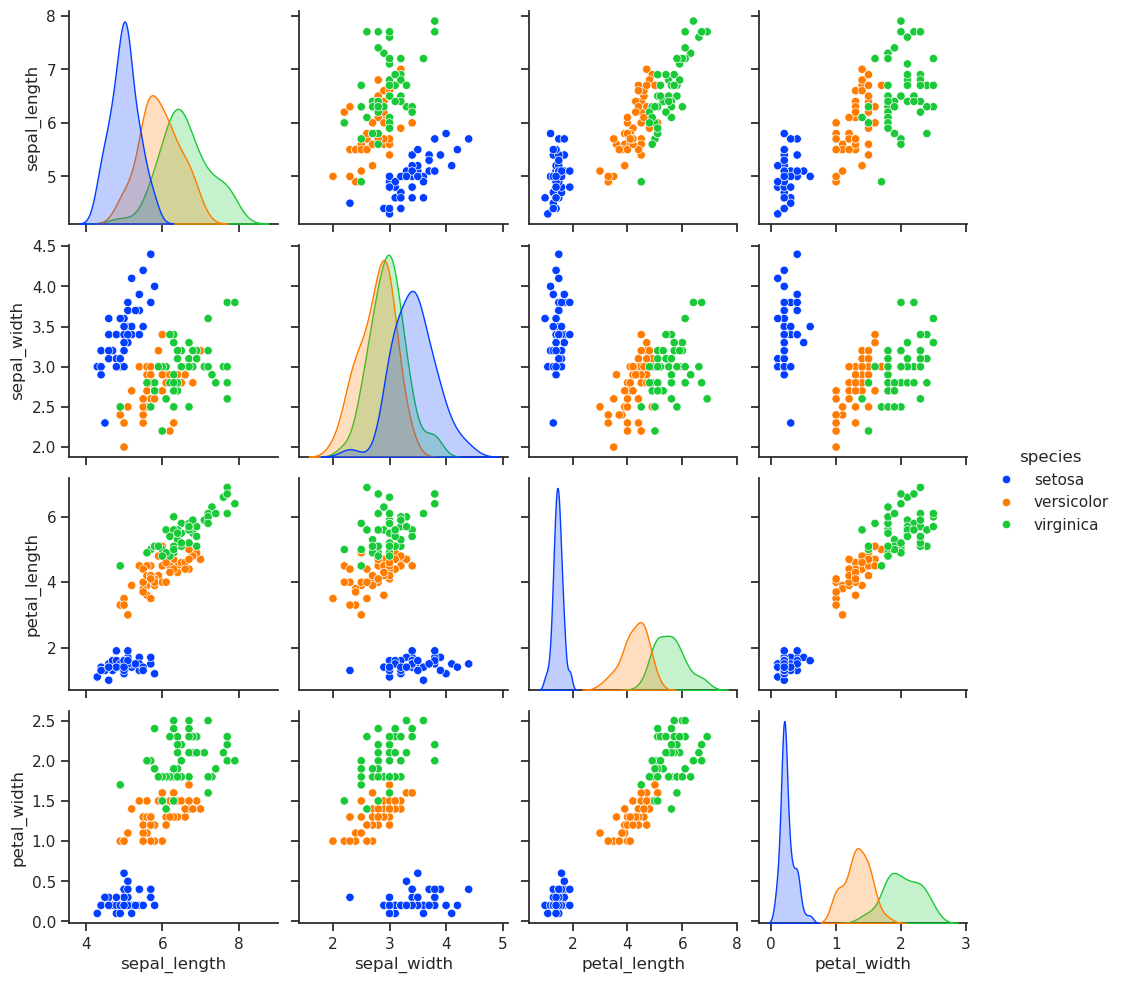

In [5]:

# Importujemy wymagane biblioteki
from sklearn.datasets import load_iris
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Wczytanie zbioru danych Iris
iris = load_iris()

# Konwersja danych do formatu pandas DataFrame
iris_df = pd.DataFrame(data=iris.data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
iris_df['species'] = pd.Categorical.from_codes(iris.target, categories=iris.target_names)

# Tworzenie pairplot za pomocą Seaborn
sns.set(style="ticks")
pairplot = sns.pairplot(iris_df, hue='species', diag_kind='kde', palette='bright')

# Wyświetlenie wykresu
plt.show()

### Zadanie nr 2 (1 punkt)
Powtórz zadanie nr 1, ale tym razem weź pod uwagę dwie zmienne - szerokość i długość płatka (petal width, petal length). Zwizualizuj granicę decyzyjną klasyfikatora.

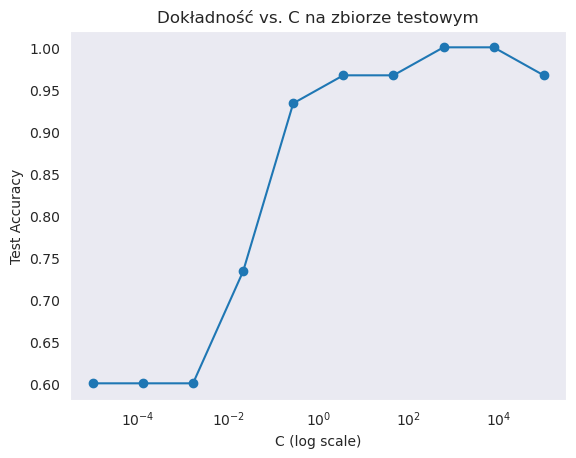

Najlepsze C: 46.41588833612782


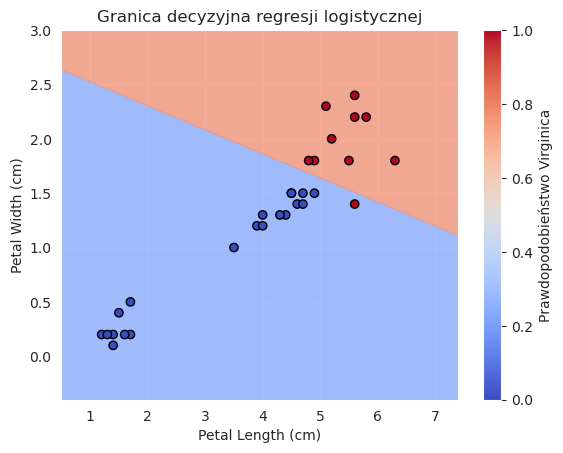

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. Wczytanie danych
iris = load_iris()

iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)

# Zmieniamy nazwy kolumn na krótsze (bez spacji i bez (cm))
iris_df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']


iris_df['species'] = pd.Categorical.from_codes(iris.target, categories=iris.target_names)
iris_df['is_virginica'] = (iris_df['species'] == 'virginica').astype(int)

# 2. Wybór dwoch cech
X = iris_df[['petal_length', 'petal_width']].values
y = iris_df['is_virginica'].values

# 3. Podział danych
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# 4. GridSearchCV
param_grid = {'C': np.logspace(-5, 5, 10)}
grid = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid.fit(X_train, y_train)

# 5. Wykres: Dokładność vs C
test_scores = []
for C in param_grid['C']:
    model = LogisticRegression(C=C, solver='liblinear')
    model.fit(X_train, y_train)
    test_score = model.score(X_test, y_test)
    test_scores.append(test_score)

plt.plot(param_grid['C'], test_scores, marker='o')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Test Accuracy')
plt.title('Dokładność vs. C na zbiorze testowym')
plt.grid()
plt.show()

# 6. Wykres: Granica decyzyjna
best_C = grid.best_params_['C']
best_model = LogisticRegression(C=best_C, solver='liblinear')
best_model.fit(X_train, y_train)

best_C = grid.best_params_['C']
print("Najlepsze C:", best_C)





# Siatka punktów
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

# Przewidzenie prawdopodobieństw
Z = best_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

# Rysowanie
plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], cmap='coolwarm', alpha=0.8)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolor='k', cmap='coolwarm')
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.title('Granica decyzyjna regresji logistycznej')
plt.colorbar(label='Prawdopodobieństwo Virginica')
plt.show()






## Maszyny Wektorów Nośnych (SVM)

Maszyny Wektorów Nośnych (SVM, ang. Support Vector Machines) to modele nadzorowanego uczenia maszynowego, używane do klasyfikacji i regresji. Główna idea polega na znalezieniu **hiperpłaszczyzny**, która oddziela dane różnych klas z **maksymalnym marginesem**.

### Liniowe SVM dla klasyfikacji binarnej

Dla zbioru treningowego $ \{ (\mathbf{x}_i, y_i) \}_{i=1}^n $, gdzie $ \mathbf{x}_i \in \mathbb{R}^d $ oraz $ y_i \in \{-1, 1\} $, celem jest znalezienie hiperpłaszczyzny:

$$
f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x} + b = 0
$$

która spełnia warunek:

$$
y_i (\mathbf{w}^\top \mathbf{x}_i + b) \geq 1, \quad \forall i
$$

Problem optymalizacyjny ma postać:

$$
\min_{\mathbf{w}, b} \ \frac{1}{2} \|\mathbf{w}\|^2 \quad \text{przy założeniu} \quad y_i (\mathbf{w}^\top \mathbf{x}_i + b) \geq 1
$$

Jest to problem wypukłej optymalizacji kwadratowej. Maksymalizujemy margines $ \frac{2}{\|\mathbf{w}\|} $ między najbliższymi punktami klas, czyli tzw. **wektorami nośnymi**.

### Miękki margines (Soft Margin SVM)

Aby poradzić sobie z danymi, które nie są liniowo separowalne, wprowadza się tzw. slack variables $ \xi_i \geq 0 $:

$$
\min_{\mathbf{w}, b, \boldsymbol{\xi}} \ \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^n \xi_i \quad \text{przy założeniu} \quad y_i (\mathbf{w}^\top \mathbf{x}_i + b) \geq 1 - \xi_i
$$

gdzie $ C > 0 $ to parametr regularyzacji, który równoważy kompromis między szerokością marginesu a karą za błędy klasyfikacji.

### Postać dualna

SVM często rozwiązuje się w postaci dualnej. Problem dualny ma postać:

$$
\max_{\boldsymbol{\alpha}} \sum_{i=1}^n \alpha_i - \frac{1}{2} \sum_{i,j=1}^n \alpha_i \alpha_j y_i y_j \langle \mathbf{x}_i, \mathbf{x}_j \rangle
\quad \text{przy założeniach} \quad
0 \leq \alpha_i \leq C, \quad \sum_{i=1}^n \alpha_i y_i = 0
$$

Tylko te obserwacje, dla których $ \alpha_i > 0 $, stają się **wektorami nośnymi**.

---

## Sztuczka Jądra (Kernel Trick)

Gdy dane nie są liniowo separowalne w przestrzeni wejściowej $ \mathbb{R}^d $, można je przekształcić do przestrzeni cech o wyższej wymiarowości przy pomocy odwzorowania $ \phi: \mathbb{R}^d \rightarrow \mathcal{H} $. Jednak obliczanie $ \phi(\mathbf{x}) $ może być kosztowne lub niewykonalne.

**Sztuczka jądra** pozwala tego uniknąć, definiując funkcję jądra $ K $ taką, że:

$$
K(\mathbf{x}_i, \mathbf{x}_j) = \langle \phi(\mathbf{x}_i), \phi(\mathbf{x}_j) \rangle
$$

Dzięki temu postać dualna może być wyrażona tylko przy pomocy funkcji jądra:

$$
\max_{\boldsymbol{\alpha}} \sum_{i=1}^n \alpha_i - \frac{1}{2} \sum_{i,j=1}^n \alpha_i \alpha_j y_i y_j K(\mathbf{x}_i, \mathbf{x}_j)
$$

### Przykładowe funkcje jądra

1. **Jądro liniowe**:
$$
K(\mathbf{x}, \mathbf{z}) = \mathbf{x}^\top \mathbf{z}
$$

2. **Jądro wielomianowe**:`
$$
K(\mathbf{x}, \mathbf{z}) = (\mathbf{x}^\top \mathbf{z} + c)^d
$$

3. **Jądro RBF / Gaussowskie**:
$$
K(\mathbf{x}, \mathbf{z}) = \exp\left(-\frac{\|\mathbf{x} - \mathbf{z}\|^2}{2\sigma^2}\right)
$$

4. **Jądro sigmoidalne** (związane z sieciami neuronowymi):
$$
K(\mathbf{x}, \mathbf{z}) = \tanh(\kappa \mathbf{x}^\top \mathbf{z} + \theta)
$$

### Funkcja decyzyjna

Po nauczeniu modelu, funkcja decyzyjna dla nowego punktu $ \mathbf{x} $ to:

$$
f(\mathbf{x}) = \text{sign} \left( \sum_{i=1}^n \alpha_i y_i K(\mathbf{x}_i, \mathbf{x}) + b \right)
$$

Tylko wektory nośne mają wpływ na wartość tej funkcji, co sprawia, że predykcja w SVM jest wydajna obliczeniowo.

### Zadanie 3 (5 punktów)

Zbadaj, jak różne jądra (kernel functions) i ich parametry wpływają na jakość klasyfikacji oraz kształt granicy decyzyjnej w klasyfikacji danych make_moons:
- Podziel dane na treningowe, testowe i walidacyjne.
- Zrób grid searcha po hiperparameterach, by znaleźć te najlepsze. Grid search powinien być zrobiony dla jądra: liniowego, wielomianowego, RBF i sigmoidalnego.
- Wykorzstaj metryki: F1 score, precision oraz accuracy do oceny jakości modelu.
- Dla każdego jądra z najlepszymi hiperparametrami zwizualizuj granicę decyzyjną.


    kernel      C  f1_score  precision  accuracy  coef0  degree  gamma
0   linear   0.10  0.827586   0.878049      0.85    NaN     NaN    NaN
1     poly   1.00  0.931818   0.976190      0.94    1.0     4.0    NaN
2      rbf  10.00  0.943820   0.976744      0.95    NaN     NaN  scale
3  sigmoid   0.01  0.827586   0.878049      0.85    1.0     NaN      1



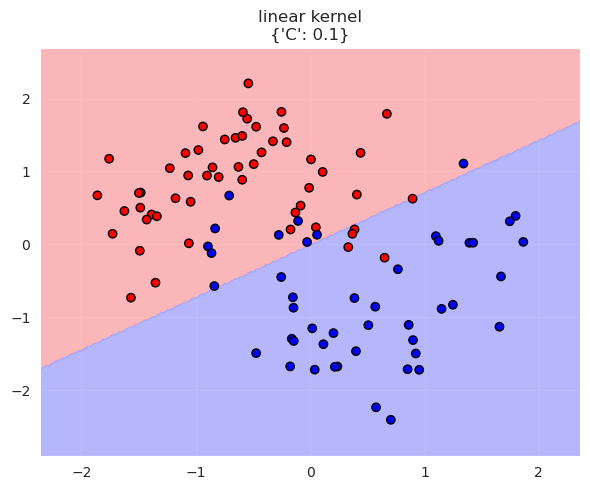

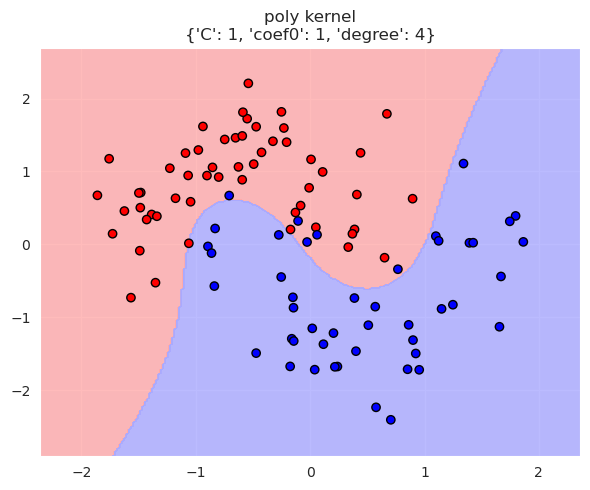

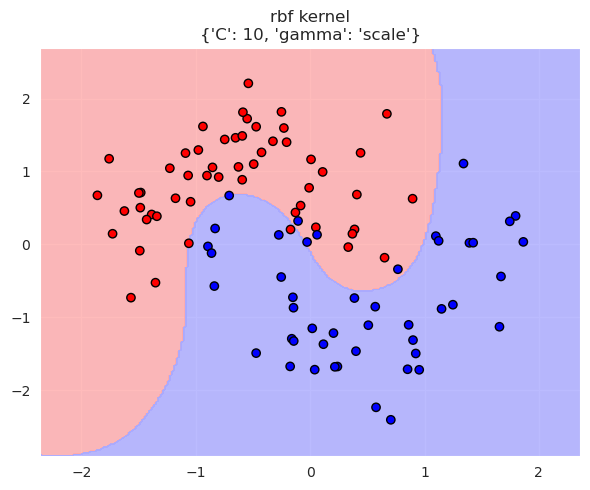

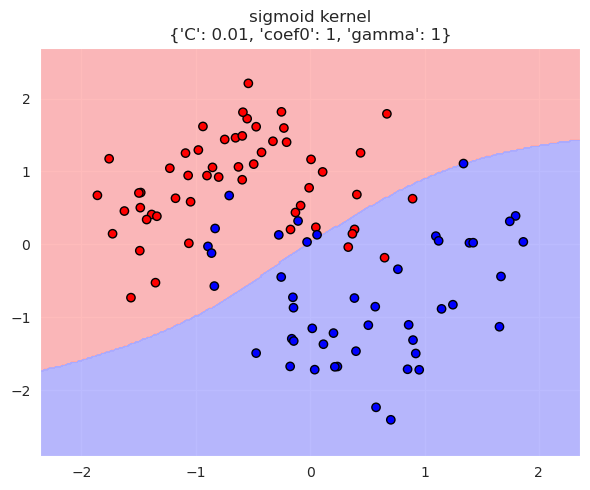

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
import pandas as pd

# Dane
X, y = make_moons(n_samples=500, noise=0.25, random_state=42)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Hiperparametry
param_grid = {
    'linear': {'C': [0.01, 0.1, 1, 10, 100]},
    'poly': {'C': [0.01, 0.1, 1, 10], 'degree': [2, 3, 4], 'coef0': [0, 1]},
    'rbf': {'C': [0.01, 0.1, 1, 10, 100], 'gamma': ['scale', 0.1, 1, 10]},
    'sigmoid': {'C': [0.01, 0.1, 1, 10, 100], 'gamma': ['scale', 0.1, 1], 'coef0': [0, 1]},
}


metrics_log = []


def train_and_evaluate(kernel, param_grid):
    svc = SVC(kernel=kernel)
    grid = GridSearchCV(svc, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_val)
    f1 = f1_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)

    row = {
        'kernel': kernel,
        **grid.best_params_,
        'f1_score': f1,
        'precision': precision,
        'accuracy': accuracy
    }
    metrics_log.append(row)
    return grid.best_params_, f1, precision, accuracy, best_model


results = {}
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    params, f1, prec, acc, model = train_and_evaluate(kernel, param_grid[kernel])
    results[kernel] = {'params': params, 'f1': f1, 'precision': prec, 'accuracy': acc, 'model': model}

df = pd.DataFrame(metrics_log)
print(df)
print()

# Wizualizacja
def plot_decision_boundary(model, X, y, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])
    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k')
    plt.title(title)
    plt.tight_layout()
    plt.show()

for kernel in results:
    plot_decision_boundary(results[kernel]['model'], X_val, y_val,
                           f"{kernel} kernel\n{results[kernel]['params']}")


In [22]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform


import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
import pandas as pd

# Dane
X, y = make_moons(n_samples=500, noise=0.25, random_state=42)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

param_distributions = {
    'C': uniform(0.01, 100),
    'gamma': ['scale', 0.01 ,0.1, 1, 10, 100],
    'degree': [1, 2, 3, 4, 5],
    'coef0': [0, 1, 2]
}

search = RandomizedSearchCV(SVC(kernel='rbf'), param_distributions, n_iter=20, cv=5)
search.fit(X_train, y_train)
best_model = search.best_estimator_
y_pred = best_model.predict(X_val)
f1 = f1_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)

print(search.best_params_)



{'C': np.float64(58.68450668849877), 'coef0': 1, 'degree': 3, 'gamma': 1}
